<a href="https://colab.research.google.com/github/rkti498/e_shikaku/blob/main/day12_03_arranged_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0# さらに改善したネットワーク
### MNIST学習モデルに勾配消失対策などを追加実装。


In [ ]:
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath("__file__"))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [ ]:



class Funcs:

  # 中間層の活性化関数
  # シグモイド関数（ロジスティック関数）
  def sigmoid(self, x):
      return 1/(1 + np.exp(-x))

  # ReLU関数
  def relu(self, x):
      return np.maximum(0, x)

  # ステップ関数（閾値0）
  def step_function(self, x):
      return np.where( x > 0, 1, 0) 

  # 出力層の活性化関数
  # ソフトマックス関数
  def softmax(self, x):
      if x.ndim == 2:
          x = x.T
          x = x - np.max(x, axis=0)
          y = np.exp(x) / np.sum(np.exp(x), axis=0)
          return y.T

      x = x - np.max(x) # オーバーフロー対策
      return np.exp(x) / np.sum(np.exp(x))

  # ソフトマックスとクロスエントロピーの複合関数
  def softmax_with_loss(self, d, x):
      y = softmax(x)
      return cross_entropy_error(d, y)

  # 誤差関数
  # 平均二乗誤差
  def mean_squared_error(self, d, y):
      return np.mean(np.square(d - y)) / 2

  # クロスエントロピー
  def cross_entropy_error(self, d, y):
      if y.ndim == 1:
          d = d.reshape(1, d.size)
          y = y.reshape(1, y.size)
          
      # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
      if d.size == y.size:
          d = d.argmax(axis=1)
              
      batch_size = y.shape[0]
      return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size



  # 活性化関数の導関数
  # シグモイド関数（ロジスティック関数）の導関数
  def d_sigmoid(self, x):
      dx = (1.0 - sigmoid(x)) * sigmoid(x)
      return dx

  # ReLU関数の導関数
  def d_relu(self, x):
      return np.where( x > 0, 1, 0)
      
  # ステップ関数の導関数
  def d_step_function(self, x):
      return 0

  # 平均二乗誤差の導関数
  def d_mean_squared_error(self, d, y):
      if type(d) == np.ndarray:
          batch_size = d.shape[0]
          dx = (y - d)/batch_size
      else:
          dx = y - d
      return dx


  # ソフトマックスとクロスエントロピーの複合導関数
  def d_softmax_with_loss(self, d, y):
      batch_size = d.shape[0]
      if d.size == y.size: # 教師データがone-hot-vectorの場合
          dx = (y - d) / batch_size
      else:
          dx = y.copy()
          dx[np.arange(batch_size), d] -= 1
          dx = dx / batch_size
      return dx

  # シグモイドとクロスエントロピーの複合導関数
  def d_sigmoid_with_loss(self, d, y):
      return y - d

  # 数値微分
  def numerical_gradient(self, f, x):
      h = 1e-4
      grad = np.zeros_like(x)

      for idx in range(x.size):
          tmp_val = x[idx]
          # f(x + h)の計算
          x[idx] = tmp_val + h
          fxh1 = f(x)

          # f(x - h)の計算
          x[idx] = tmp_val - h
          fxh2 = f(x)

          grad[idx] = (fxh1 - fxh2) / (2 * h)
          # 値を元に戻す
          x[idx] = tmp_val

      return grad

In [ ]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:

funcs = Funcs()
print(funcs.relu([-3, -2, -1, 0, 1, 2, 3]))


[0 0 0 0 1 2 3]


In [ ]:
# ReLU layer
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # mask.shape = x.shape
        # True or Falseを要素として持つ
        self.mask = (x <= 0)
        out = x.copy()
        # Trueの箇所を0にする
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # Trueの箇所を0にする
        dout[self.mask] = 0
        dx = dout

        return dx
    
# Affine layer(全結合 layer)
class Affine:
    
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応        
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

        
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = funcs.sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx        

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.d = None # 教師データ

    def forward(self, x, d):
        self.d = d
        self.y = funcs.softmax(x)
        self.loss = funcs.cross_entropy_error(self.d, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.d.shape[0]
        if self.d.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.d) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.d] -= 1
            dx = dx / batch_size
        
        return dx

class BatchNormalization:
    '''
    gamma: スケール係数
    beta: オフセット
    momentum: 慣性
    running_mean: テスト時に使用する平均
    running_var: テスト時に使用する分散
    '''

    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [ ]:
import numpy as np

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, params, grad):
        for key in params.keys():
            params[key] -= self.learning_rate * grad[key] 


class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grad):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad[key] 
            params[key] += self.v[key]


class Nesterov:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grad):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.learning_rate * grad[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.learning_rate * grad[key]


class AdaGrad:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.h = None
        
    def update(self, params, grad):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grad[key] * grad[key]
            params[key] -= self.learning_rate * grad[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:
    def __init__(self, learning_rate=0.01, decay_rate = 0.99):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grad):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grad[key] * grad[key]
            params[key] -= self.learning_rate * grad[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grad):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.learning_rate * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grad[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grad[key] ** 2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

データ読み込み完了
sigmoid:0.01:batch_norm-False: 500. 正答率(トレーニング) = 0.12 : 500. 正答率(テスト) = 0.1032
sigmoid:0.01:batch_norm-False: 1000. 正答率(トレーニング) = 0.07 : 1000. 正答率(テスト) = 0.1135
sigmoid:0.01:batch_norm-False: 1500. 正答率(トレーニング) = 0.12 : 1500. 正答率(テスト) = 0.1028
sigmoid:0.01:batch_norm-False: 2000. 正答率(トレーニング) = 0.15 : 2000. 正答率(テスト) = 0.0974
sigmoid:0.01:batch_norm-True: 500. 正答率(トレーニング) = 0.91 : 500. 正答率(テスト) = 0.8632
sigmoid:0.01:batch_norm-True: 1000. 正答率(トレーニング) = 0.98 : 1000. 正答率(テスト) = 0.8817
sigmoid:0.01:batch_norm-True: 1500. 正答率(トレーニング) = 0.97 : 1500. 正答率(テスト) = 0.911
sigmoid:0.01:batch_norm-True: 2000. 正答率(トレーニング) = 0.99 : 2000. 正答率(テスト) = 0.9147
sigmoid:Xavier:batch_norm-False: 500. 正答率(トレーニング) = 0.55 : 500. 正答率(テスト) = 0.6168
sigmoid:Xavier:batch_norm-False: 1000. 正答率(トレーニング) = 0.8 : 1000. 正答率(テスト) = 0.7645
sigmoid:Xavier:batch_norm-False: 1500. 正答率(トレーニング) = 0.83 : 1500. 正答率(テスト) = 0.8505
sigmoid:Xavier:batch_norm-False: 2000. 正答率(トレーニング) = 0.89 : 2000. 正答率(テスト) = 0.8824
sigmoid:Xa

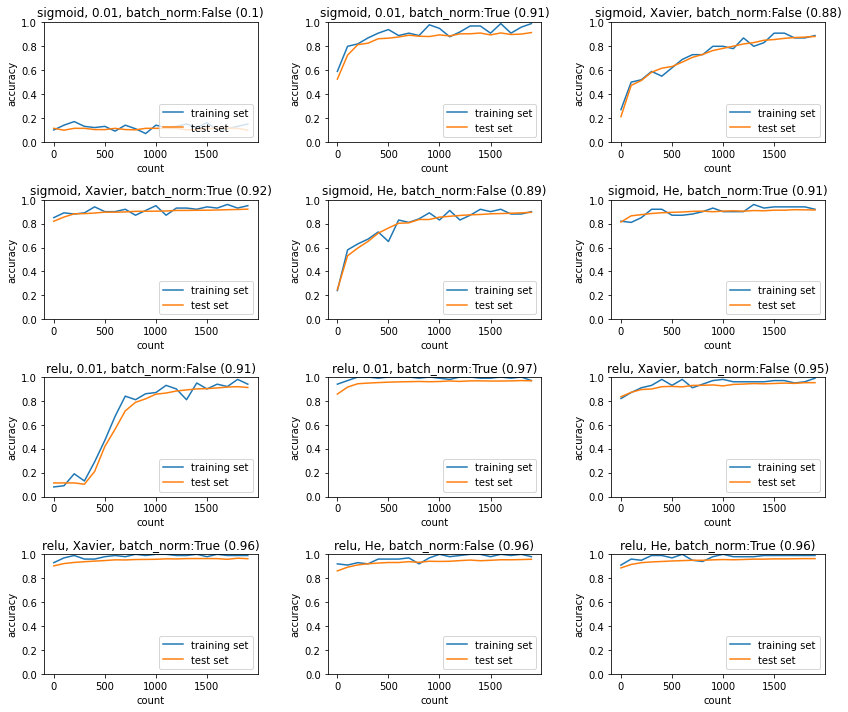

In [ ]:
import sys, os
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    weight_decay_lambda: L2正則化の強さ
    use_dropout: ドロップアウトの有無
    dropout_ratio: ドロップアウト率
    use_batchnorm: バッチ正規化の有無
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ratio = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1]) 
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, d, train_flg=False):
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, X, D):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if D.ndim != 1 : D = np.argmax(D, axis=1)

        accuracy = np.sum(Y == D) / float(X.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads
 

# データの読み込み
# (x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print('データ読み込み完了')

activations = ['sigmoid', 'relu']
weight_init_stds = [0.01, 'Xavier', 'He']
use_batchnorms = [False, True]

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

plot_interval = 100
plot_idx = 0 

for k in range(len(activations)):
    for l in range(len(weight_init_stds)):
        for m in range(len(use_batchnorms)):
            network = MultiLayerNet(
                    input_size=784,
                    hidden_size_list=[40, 20],
                    output_size=10,
                    activation=activations[k],
                    weight_init_std=weight_init_stds[l],
                    use_batchnorm=use_batchnorms[m])

            train_loss_list = []
            accuracies_train = []
            accuracies_test = []
            lists = []
            plot_idx = plot_idx + 1

            for i in range(iters_num):            
                batch_mask = np.random.choice(train_size, batch_size)
                x_batch = x_train[batch_mask]
                d_batch = d_train[batch_mask]

                # 勾配
                grad = network.gradient(x_batch, d_batch)

                for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
                    network.params[key] -= learning_rate * grad[key]

                loss = network.loss(x_batch, d_batch)
                train_loss_list.append(loss)

                if (i + 1) % plot_interval == 0:
                    accr_test = network.accuracy(x_test, d_test)
                    accuracies_test.append(accr_test)        
                    accr_train = network.accuracy(x_batch, d_batch)
                    accuracies_train.append(accr_train)

                    if (i + 1) % (plot_interval * 5) == 0:
                        network_prop = activations[k] + ':' + str(weight_init_stds[l]) + ':' + 'batch_norm-' + str(use_batchnorms[m])
                        print(network_prop + ': ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train) + \
                              ' : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))


            lists = range(0, iters_num, plot_interval)

            plt.rcParams['figure.figsize'] = (12.0, 10.0)
            plt.subplot(4,3,plot_idx)
            plt.plot(lists, accuracies_train, label='training set')
            plt.plot(lists, accuracies_test,  label='test set')
            plt.legend(loc='lower right')
            plt.title(activations[k] + ', '  + str(weight_init_stds[l]) + ', batch_norm:'  + str(use_batchnorms[m]) + ' ('  + str(np.round(accuracies_test[-1],2)) + ')')
            plt.xlabel('count')
            plt.ylabel('accuracy')
            plt.ylim(0, 1.0)

# グラフの表示
plt.tight_layout()
# plt.suptitle('活性化関数および重みの初期値を変更した場合の予測精度', fontsize = 16)
plt.show()

### 考察
勾配消失対策の実装を確認  
最適化：update関数をもつ。パラメータと勾配を受け取ってパラメータを更新  
バッチ正規化：0を中心としたセンタリング処理を行っている。  



以下の条件で比較
```
sigmoid:0.01:batch_norm-False:0.0974
sigmoid:0.01:batch_norm-True:0.9147
sigmoid:Xavier:batch_norm-False:0.8824
sigmoid:Xavier:batch_norm-True:0.921
sigmoid:He:batch_norm-False:0.8944
sigmoid:He:batch_norm-True:0.9136
relu:0.01:batch_norm-False:0.9122
relu:0.01:batch_norm-True:0.968
relu:Xavier:batch_norm-False:0.9527
relu:Xavier:batch_norm-True:0.9632
relu:He:batch_norm-False:0.9583
relu:He:batch_norm-True:0.9637
```
ReLU関数の方が全体的に正答率が高い。
ReLUの初期化はHeが推奨されるのが通説だが、この例だと結果はほとんど変わらないように見える。

多数のモデルで勾配消失対策を行わなかった02_modified_networkの正答率を超えているのが分かる。